# InceptionResNetV2

## Get embeddings
I just download this model from Keras and inference it following their example

In [8]:
# Load images
import numpy as np
from PIL import Image
import os

# Training
image_folder = "images/training_imgs"

# Break into categories
clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_filenames = [file for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

full_body_unedited = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("fb-unedited.png")]

# Test
image_folder = "images/example_imgs"

# Break into categories
test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder)]

In [20]:
len(full_body_images)

1260

In [10]:
# Create embeddings
import tensorflow as tf

def sample_generator(dataset):
    for sample in dataset:
        yield tf.keras.applications.inception_resnet_v2.preprocess_input(np.array(sample))

img_spec = tf.TensorSpec((488, 488, 3), float)
ds_clothing = tf.data.Dataset.from_generator(lambda: sample_generator(clothing_images), output_signature=img_spec).batch(32)
ds_outfit = tf.data.Dataset.from_generator(lambda: sample_generator(full_body_images), output_signature=img_spec).batch(32)
ds_test = tf.data.Dataset.from_generator(lambda: sample_generator(test_clothing_images), output_signature=img_spec).batch(32)

model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(488, 488, 3),
    pooling="avg"
)

clothing_embed = model.predict(ds_clothing)
full_body_embed = model.predict(ds_outfit)
test_embed = model.predict(ds_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 311ms/step


2024-05-06 02:01:19.687411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step


2024-05-06 02:01:27.823261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


2024-05-06 02:01:33.528037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualize model embeddings

In [11]:
# Load images
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Break into categories
clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.22040646 0.14794177] 0.36834822595119476
[0.1574998  0.10152176] 0.2590215653181076


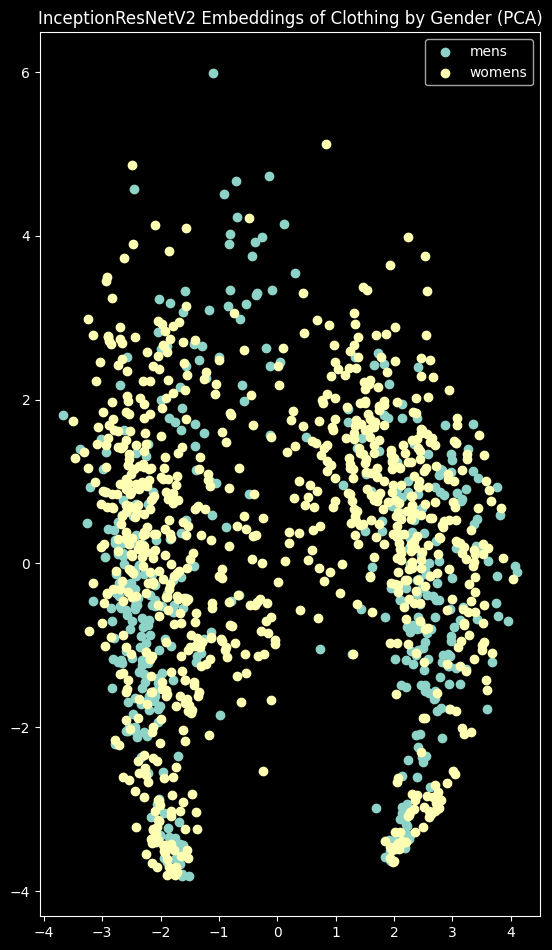

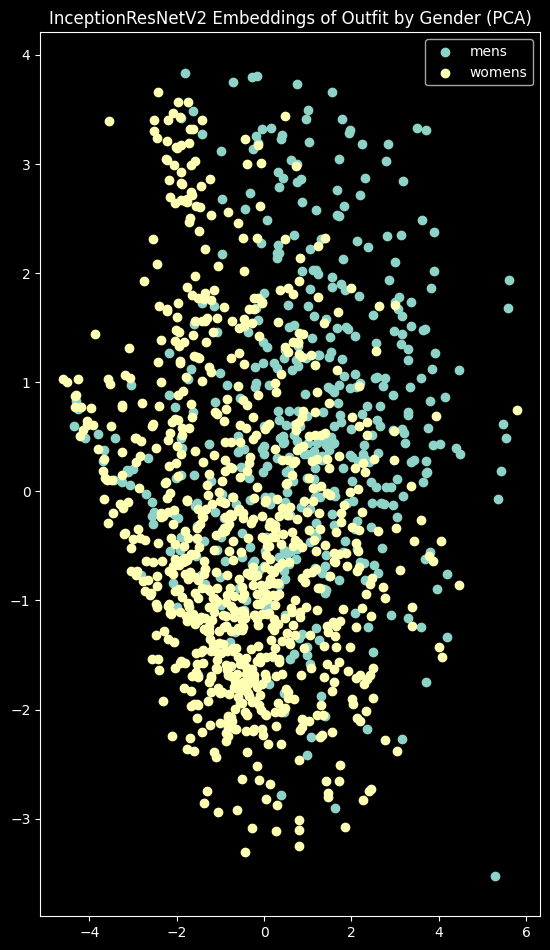

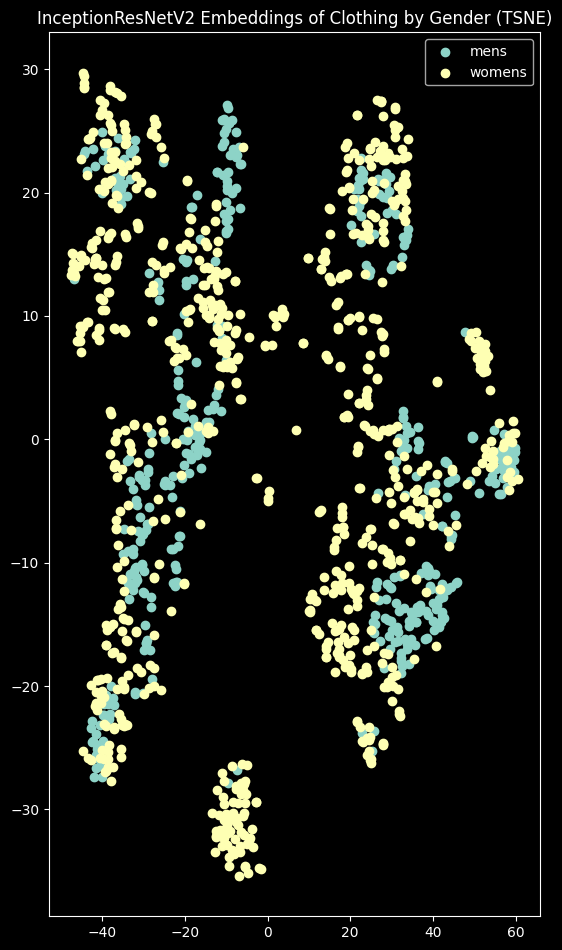

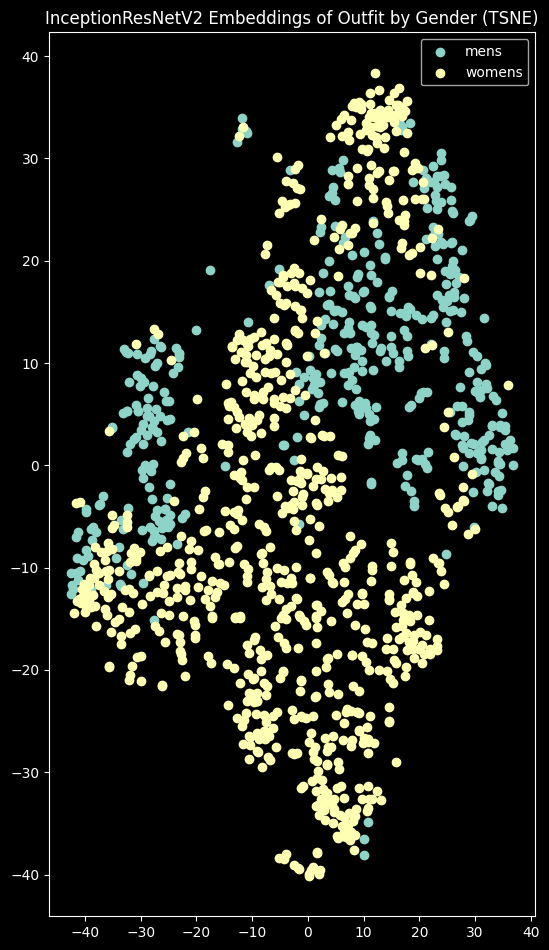

In [22]:
# Plot gendered items
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("InceptionResNetV2 Embeddings of Clothing by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("InceptionResNetV2 Embeddings of Outfit by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("InceptionResNetV2 Embeddings of Clothing by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("InceptionResNetV2 Embeddings of Outfit by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

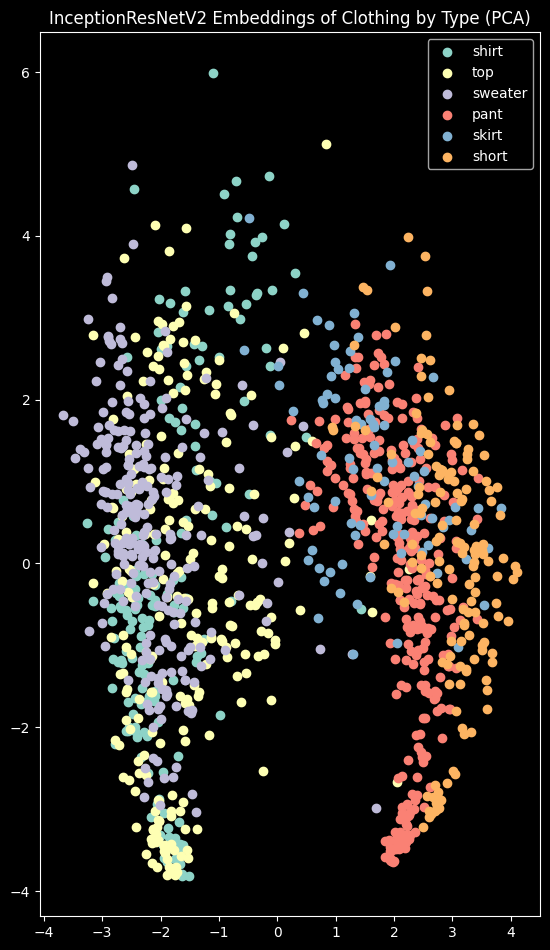

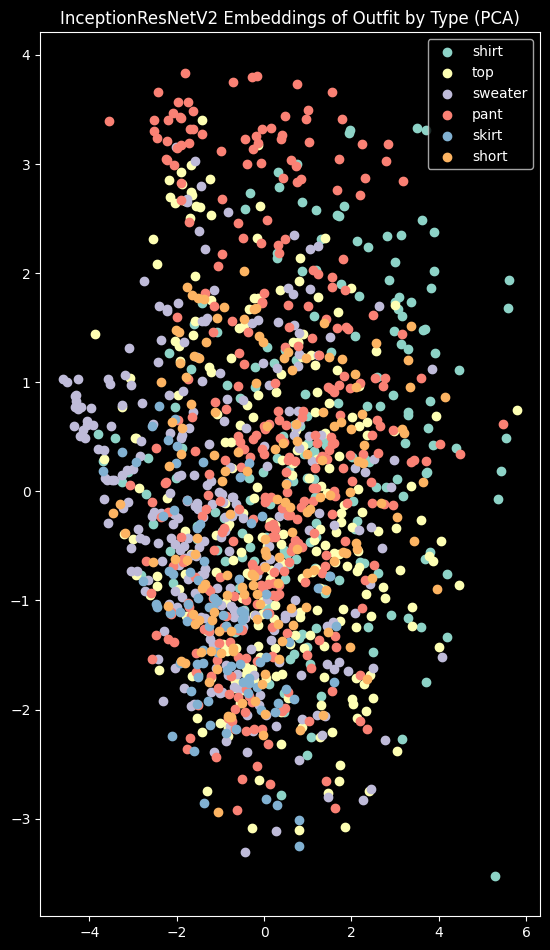

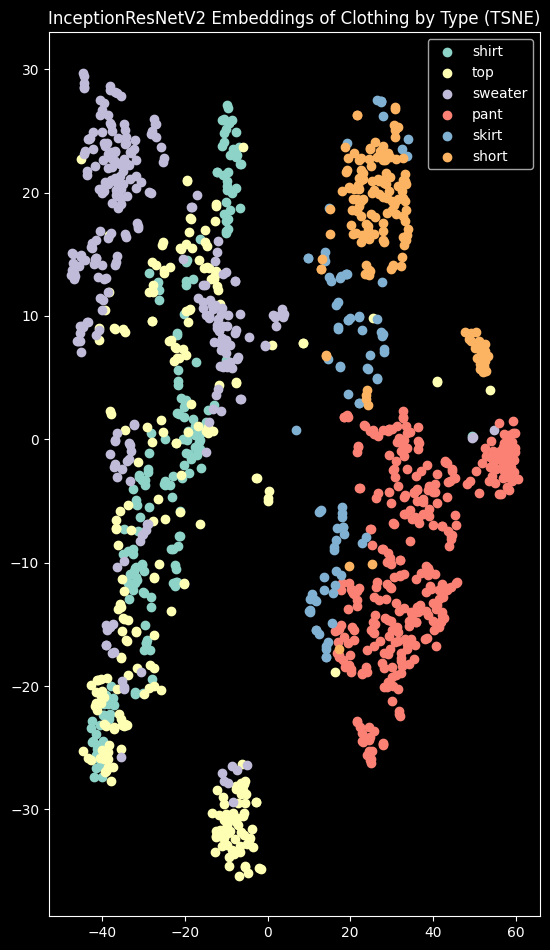

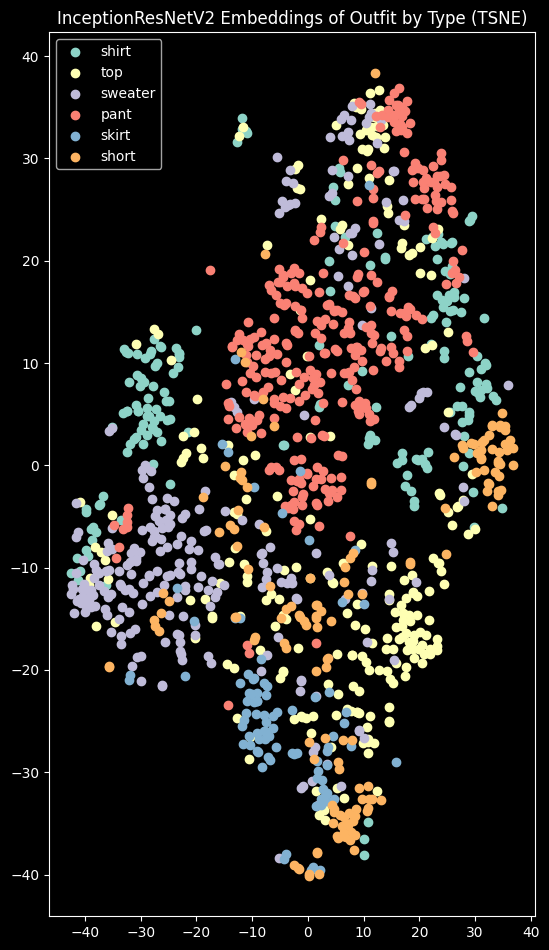

In [25]:
# Plot types of items

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("InceptionResNetV2 Embeddings of Clothing by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("InceptionResNetV2 Embeddings of Outfit by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("InceptionResNetV2 Embeddings of Clothing by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("InceptionResNetV2 Embeddings of Outfit by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

## Testing embeddings using KNN

In [27]:
from sklearn.model_selection import train_test_split

y_map = {"shirt": 0, "top": 0, "sweater": 1, "pant": 2, "skirt": 3, "short": 4}
y = np.array([y_map[label[2]] for label in clothing_labels])
X_train, X_test, y_train, y_test = train_test_split(clothing_embed, y, test_size=0.25)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

matrix = confusion_matrix(y_test, knn.predict(X_test))
acc_per_class = matrix.diagonal()/matrix.sum(axis=1)

print(acc_per_class)

[0.94059406 0.89552239 1.         0.70588235 0.91304348]


## Plot demo outfits

In [29]:
# Refit KNN on all training

knn.fit(clothing_embed, y)

KNeighborsClassifier()

983
1239
301
1098
239


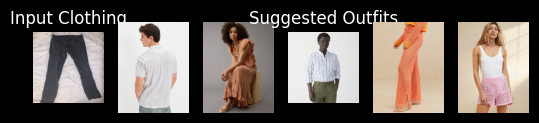

502
1105
1201
585
870


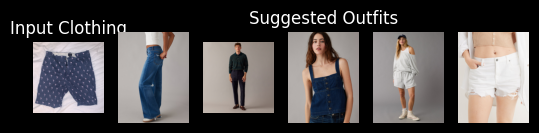

798
534
1001
355
516


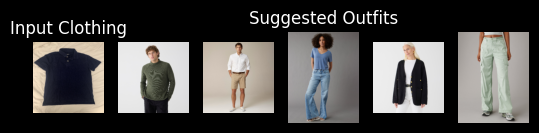

103
934
1240
1250
738


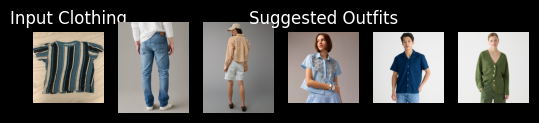

980
135
385
410
1225


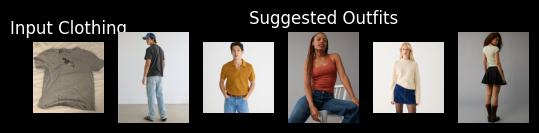

728
848
917
531
885


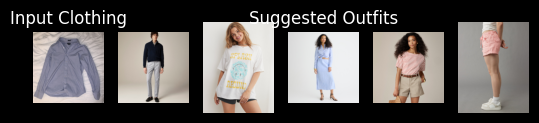

In [37]:
# Generate suggested outfits

for i, test_emb in enumerate(test_embed):
    _, axs = plt.subplots(1, 6)
    axs[0].axis("off")
    axs[0].set_title("Input Clothing")
    axs[0].imshow(test_clothing_images[i])
    axs[3].set_title("Suggested Outfits")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    for j, ind in enumerate(inds[0]):
        print(ind)
        axs[j + 1].axis("off")
        axs[j + 1].imshow(full_body_unedited[ind])

    plt.show()